In [ ]:
!pip install tensorflow-addons

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 6.1 MB/s eta 0:00:00
  Attempting uninstall: typeguard
    Found existing installation: typeguard 4.4.4
    Uninstalling typeguard-4.4.4:
      Successfully uninstalled typeguard-4.4.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
inflect 7.5.0 requires typeguard>=4.0.1, but you have typeguard 2.13.3 which is incompatible.


# Import Library & Google Drive access

In [ ]:
import os
import pathlib
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
import tensorflow.keras.backend as K
from google.colab import drive

drive.mount('/content/drive')

class CategoricalFocalLoss(tf.keras.losses.Loss):
    def __init__(self, gamma=2., alpha=0.25, **kwargs):
        super(CategoricalFocalLoss, self).__init__(**kwargs)
        self.gamma = gamma
        self.alpha = alpha

    def call(self, y_true, y_pred):
        y_pred = K.clip(y_pred, K.epsilon(), 1. - K.epsilon())
        cross_entropy = -y_true * K.log(y_pred)
        weight = self.alpha * K.pow(1 - y_pred, self.gamma)
        return K.sum(weight * cross_entropy, axis=1)

# Update this path as per your drive
data_root = '/content/drive/MyDrive/skin_lesion_dataset/train'
data_dir = pathlib.Path(data_root)
assert data_dir.exists(), "Dataset path incorrect!"

Mounted at /content/drive


# Count total images and class folders

In [ ]:
class_names = sorted([item.name for item in data_dir.glob('*') if item.is_dir()])
print(f"Detected classes: {class_names}")

total_images = sum([len(list((data_dir/class_name).glob('*.jpg')))
                    + len(list((data_dir/class_name).glob('*.png')))
                    + len(list((data_dir/class_name).glob('*.jpeg')))
                    for class_name in class_names])
print(f"\n Total images found: {total_images}")

Detected classes: ['Actinic keratosis', 'Atopic Dermatitis', 'Benign keratosis', 'Dermatofibroma', 'Melanoma', 'Squamous cell carcinoma', 'Tinea Ringworm Candidiasis', 'Vascular lesion']

 Total images found: 2085


# Display sample images

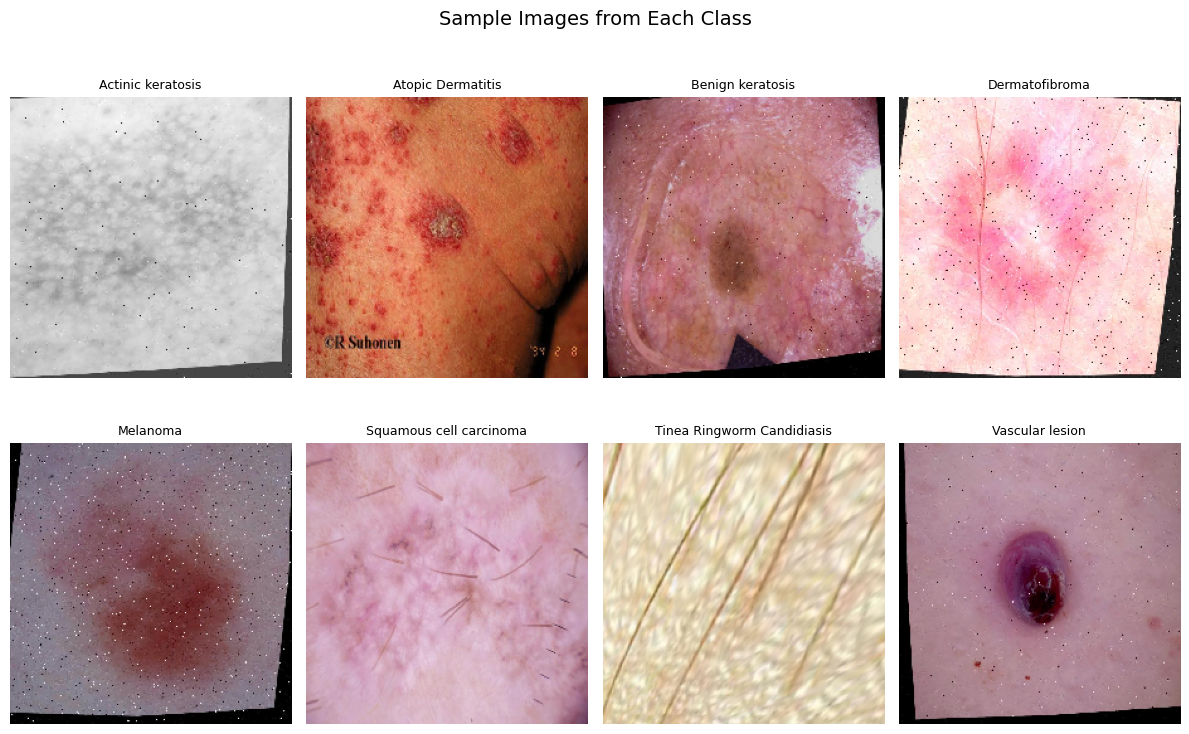

In [ ]:
import random
import cv2

plt.figure(figsize=(12, 8))
for i, cls in enumerate(class_names[:8]):
    folder = data_dir / cls
    sample = random.choice(os.listdir(folder))
    img_path = folder / sample
    img = tf.keras.utils.load_img(img_path, target_size=(224, 224))
    plt.subplot(2, 4, i + 1)
    plt.imshow(img)
    plt.title(cls, fontsize=9)
    plt.axis('off')
plt.suptitle("Sample Images from Each Class", fontsize=14)
plt.tight_layout()
plt.show()

# Load dataset using ImageDataGenerator

In [ ]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
SEED = 42

train_ds = tf.keras.utils.image_dataset_from_directory(
    data_root,
    validation_split=0.3,
    subset="training",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical'
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    data_root,
    validation_split=0.3,
    subset="validation",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical'
)

class_names = train_ds.class_names
num_classes = len(class_names)

Found 2085 files belonging to 8 classes.
Using 1460 files for training.
Found 2085 files belonging to 8 classes.
Using 625 files for validation.


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

labels = []
for _, label in train_ds.unbatch():
    labels.append(np.argmax(label.numpy()))
class_weights = compute_class_weight(class_weight='balanced',
                                     classes=np.unique(labels),
                                     y=labels)
class_weight_dict = dict(enumerate(class_weights))

# Model Builders

Epoch 1/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1251s 26s/step - accuracy: 0.2299 - loss: 2.5259 - val_accuracy: 0.3392 - val_loss: 2.0071 - learning_rate: 1.0000e-04
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1213s 26s/step - accuracy: 0.6292 - loss: 0.9004 - val_accuracy: 0.5792 - val_loss: 1.1741 - learning_rate: 1.0000e-04
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1216s 26s/step - accuracy: 0.8082 - loss: 0.4619 - val_accuracy: 0.6704 - val_loss: 0.9667 - learning_rate: 1.0000e-04
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1221s 26s/step - accuracy: 0.8984 - loss: 0.2395 - val_accuracy: 0.7168 - val_loss: 0.8272 - learning_rate: 1.0000e-04
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1214s 26s/step - accuracy: 0.9392 - loss: 0.1641 - val_accuracy: 0.6960 - val_loss: 0.9275 - learning_rate: 1.0000e-04
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1221s 26s/step - accuracy: 0.9665 - loss: 0.0848 - val_accuracy: 0.7440 - val_loss: 0.7784 - learning_rate: 1.0000e-04
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1181s 26s/step - acc

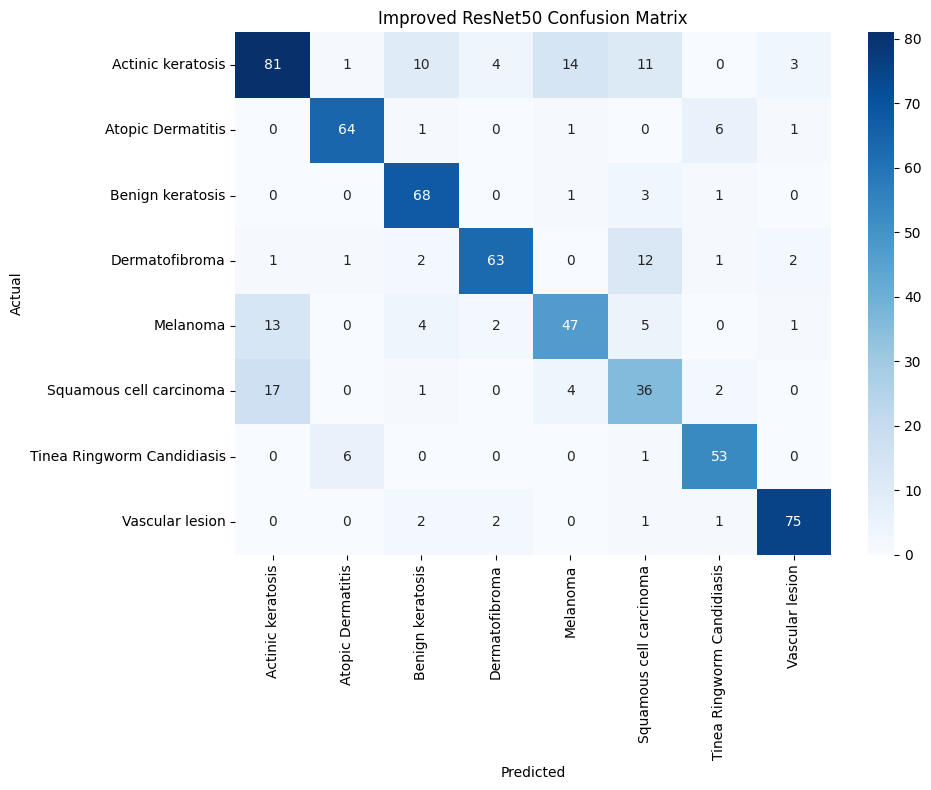

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models, optimizers, callbacks
import tensorflow as tf
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Build the model
def build_resnet_model():
    base_model = ResNet50(input_shape=(*IMG_SIZE, 3), include_top=False, weights='imagenet')
    base_model.trainable = True
    model = tf.keras.Sequential([
        layers.Input(shape=(*IMG_SIZE, 3)),
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.4),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

model = build_resnet_model()

# Compile
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks
callbacks_list = [
    callbacks.EarlyStopping(patience=10, restore_best_weights=True),
    callbacks.ReduceLROnPlateau(factor=0.5, patience=3, verbose=1),
    callbacks.ModelCheckpoint("resnet50_best_improved.keras", save_best_only=True)
]

# Train
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    class_weight=class_weight_dict,
    callbacks=callbacks_list
)

# Evaluation
y_true, y_pred = [], []
for images, labels in val_ds:
    preds = model.predict(images)
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

# Classification Report
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.title("Improved ResNet50 Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 374s 7s/step - accuracy: 0.1740 - loss: 2.9402 - val_accuracy: 0.2000 - val_loss: 2.3600 - learning_rate: 1.0000e-04
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 328s 7s/step - accuracy: 0.3528 - loss: 1.9563 - val_accuracy: 0.2880 - val_loss: 2.1743 - learning_rate: 1.0000e-04
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 382s 7s/step - accuracy: 0.4624 - loss: 1.5079 - val_accuracy: 0.3392 - val_loss: 2.1541 - learning_rate: 1.0000e-04
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 328s 7s/step - accuracy: 0.5202 - loss: 1.3409 - val_accuracy: 0.3456 - val_loss: 2.3417 - learning_rate: 1.0000e-04
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 384s 7s/step - accuracy: 0.5634 - loss: 1.1891 - val_accuracy: 0.3648 - val_loss: 2.3980 - learning_rate: 1.0000e-04
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.6350 - loss: 0.9330
Epoch 6: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
46/46 ━━━━━━━━━━━

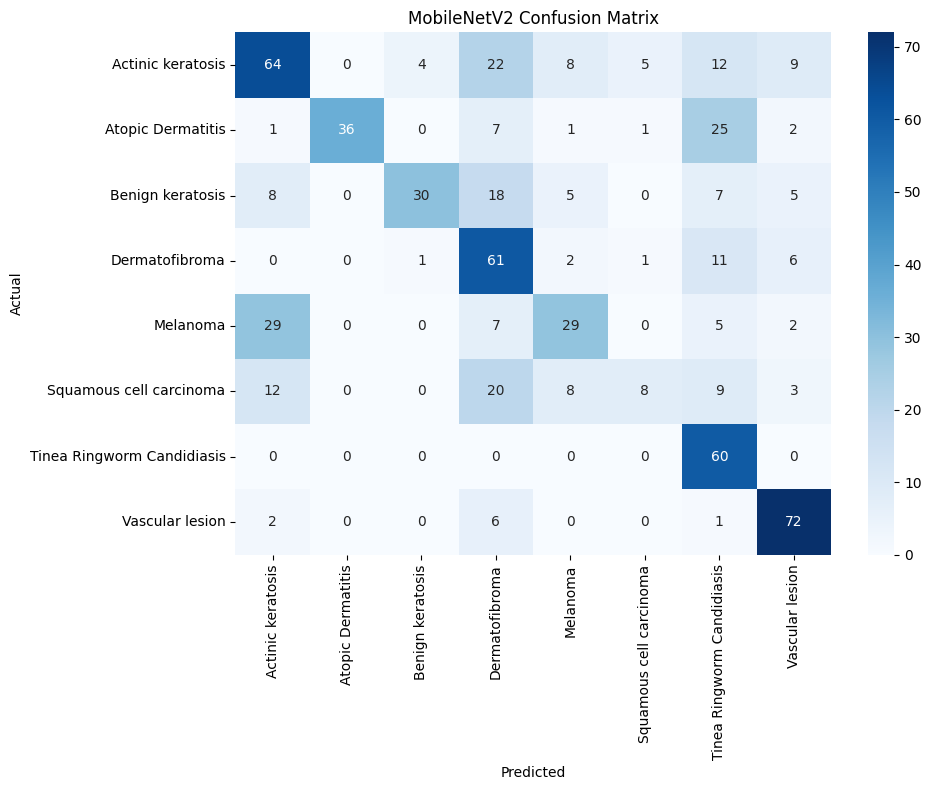

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# === Constants ===
INPUT_SHAPE = (224, 224, 3)
NUM_CLASSES = 8  # Update according to your dataset

# === Build Improved Model ===
def build_improved_mobilenetv2_model():
    base_model = MobileNetV2(input_shape=INPUT_SHAPE, include_top=False, weights='imagenet')
    base_model.trainable = True  # Unfreeze all layers

    inputs = layers.Input(shape=INPUT_SHAPE)
    x = layers.Rescaling(1./255)(inputs)
    x = layers.RandomFlip("horizontal")(x)
    x = layers.RandomRotation(0.2)(x)
    x = layers.RandomZoom(0.25)(x)
    x = base_model(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.4)(x)
    outputs = layers.Dense(NUM_CLASSES, activation='softmax')(x)

    model = models.Model(inputs, outputs)
    return model

model = build_improved_mobilenetv2_model()

# === Compile Model ===
model.compile(
    optimizer=optimizers.Adam(1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# === Callbacks ===
callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True),
    ModelCheckpoint("mobilenetv2_tuned.keras", save_best_only=True),
    ReduceLROnPlateau(factor=0.5, patience=3, verbose=1)
]

# === Train Model ===
history = model.fit(
    train_ds,  # Your tf.data.Dataset
    validation_data=val_ds,
    epochs=30,
    callbacks=callbacks,
    class_weight=class_weight_dict  # If you calculated class imbalance
)

# === Evaluate and Visualize ===
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

y_true, y_pred = [], []
for images, labels in val_ds:
    preds = model.predict(images)
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.title("MobileNetV2 Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

Training DenseNet121...
Epoch 1/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 1268s 26s/step - accuracy: 0.1942 - loss: 2.7750 - val_accuracy: 0.2608 - val_loss: 2.0058 - learning_rate: 1.0000e-04
Epoch 2/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 1203s 25s/step - accuracy: 0.4154 - loss: 1.6888 - val_accuracy: 0.4112 - val_loss: 1.6102 - learning_rate: 1.0000e-04
Epoch 3/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 1161s 25s/step - accuracy: 0.5391 - loss: 1.2892 - val_accuracy: 0.4816 - val_loss: 1.5765 - learning_rate: 1.0000e-04
Epoch 4/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 1145s 25s/step - accuracy: 0.6182 - loss: 0.9834 - val_accuracy: 0.6224 - val_loss: 1.1105 - learning_rate: 1.0000e-04
Epoch 5/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 1145s 24s/step - accuracy: 0.6400 - loss: 0.9511 - val_accuracy: 0.6576 - val_loss: 1.1100 - learning_rate: 1.0000e-04
Epoch 6/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 1129s 25s/step - accuracy: 0.6887 - loss: 0.7704 - val_accuracy: 0.6848 - val_loss: 0.9970 - learning

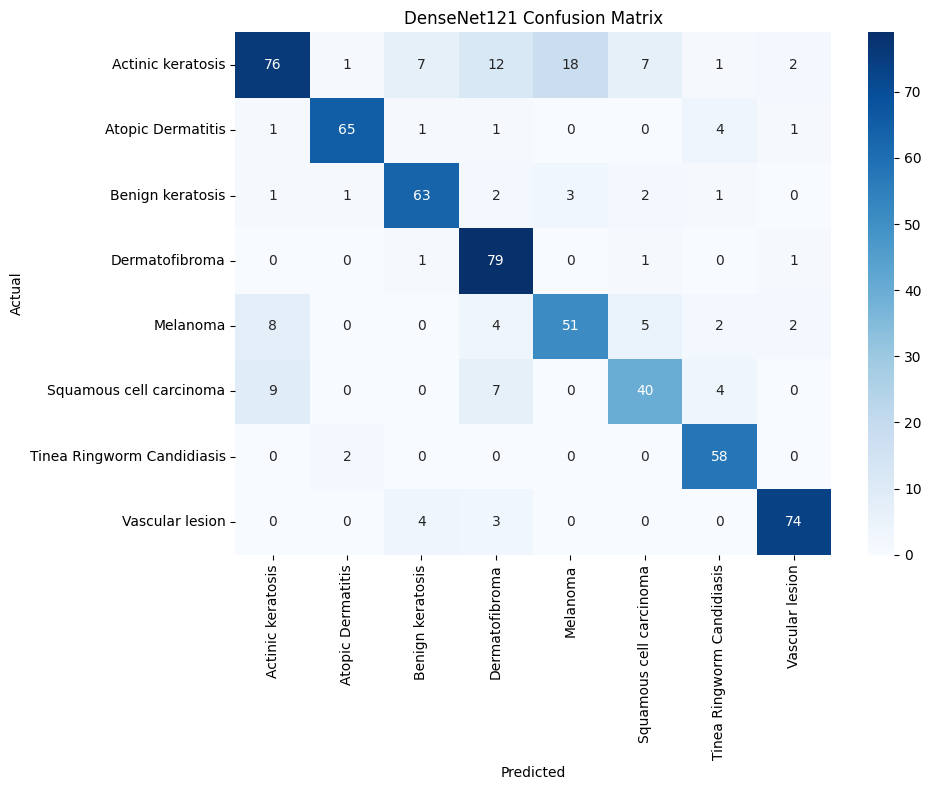

In [ ]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

INPUT_SHAPE = (224, 224, 3)
NUM_CLASSES = 8

def build_densenet_model():
    base_model = DenseNet121(input_shape=INPUT_SHAPE, include_top=False, weights='imagenet')
    base_model.trainable = True
    inputs = layers.Input(shape=INPUT_SHAPE)
    x = layers.Rescaling(1./255)(inputs)
    x = layers.RandomFlip("horizontal")(x)
    x = layers.RandomRotation(0.2)(x)
    x = layers.RandomZoom(0.25)(x)
    x = base_model(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.4)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    model = models.Model(inputs, outputs)
    return model

densenet_model = build_densenet_model()
densenet_model.compile(optimizer=optimizers.Adam(1e-4),
                       loss='categorical_crossentropy',
                       metrics=['accuracy'])

callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True),
    ModelCheckpoint("densenet121_best.keras", save_best_only=True),
    ReduceLROnPlateau(factor=0.5, patience=3, verbose=1)
]

print("\nTraining DenseNet121...")
densenet_model.fit(train_ds,
                   validation_data=val_ds,
                   epochs=20,
                   callbacks=callbacks,
                   class_weight=class_weight_dict)

# Evaluate
y_true, y_pred = [], []
for images, labels in val_ds:
    preds = densenet_model.predict(images)
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

print("\nDenseNet121 Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.title("DenseNet121 Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

Training InceptionV3...
Epoch 1/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 15s/step - accuracy: 0.1782 - loss: 2.8766 
Epoch 1: val_loss improved from inf to 1.83212, saving model to inceptionv3_best.keras
46/46 ━━━━━━━━━━━━━━━━━━━━ 888s 18s/step - accuracy: 0.1795 - loss: 2.8693 - val_accuracy: 0.3184 - val_loss: 1.8321 - learning_rate: 1.0000e-04
Epoch 2/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 15s/step - accuracy: 0.4251 - loss: 1.7442 
Epoch 2: val_loss improved from 1.83212 to 1.54482, saving model to inceptionv3_best.keras
46/46 ━━━━━━━━━━━━━━━━━━━━ 769s 17s/step - accuracy: 0.4251 - loss: 1.7428 - val_accuracy: 0.4528 - val_loss: 1.5448 - learning_rate: 1.0000e-04
Epoch 3/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 15s/step - accuracy: 0.5019 - loss: 1.4453 
Epoch 3: val_loss improved from 1.54482 to 1.35416, saving model to inceptionv3_best.keras
46/46 ━━━━━━━━━━━━━━━━━━━━ 742s 16s/step - accuracy: 0.5022 - loss: 1.4432 - val_accuracy: 0.5392 - val_loss: 

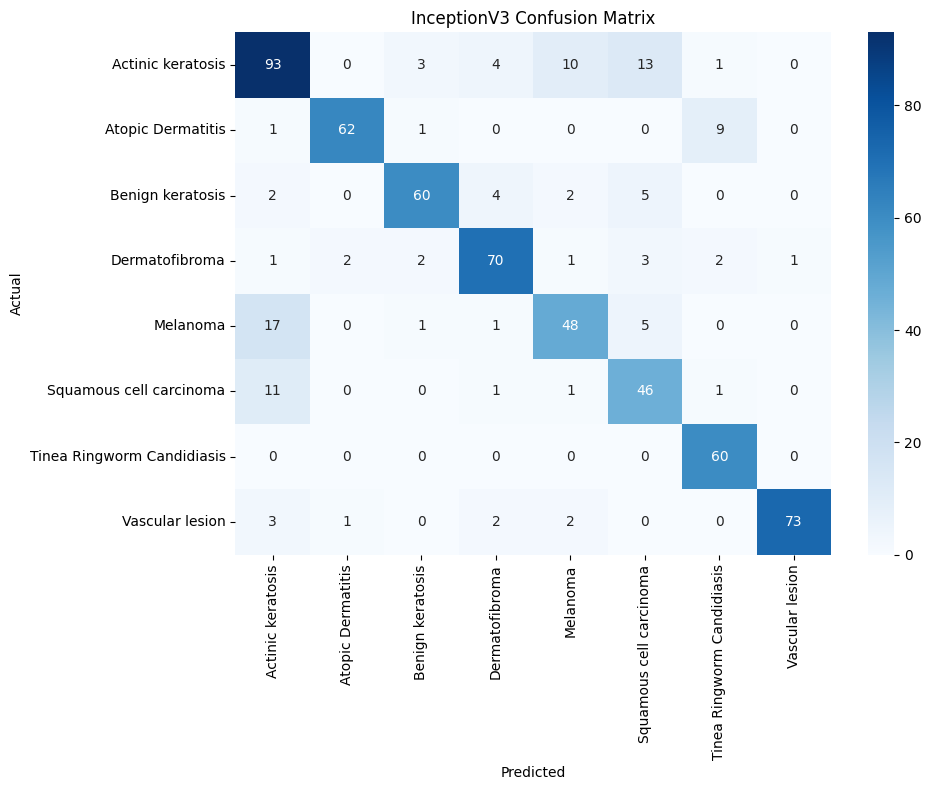

In [ ]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

INPUT_SHAPE = (224, 224, 3)
NUM_CLASSES = 8

def build_inceptionv3_model():
    base_model = InceptionV3(input_shape=INPUT_SHAPE, include_top=False, weights='imagenet')
    base_model.trainable = True
    inputs = layers.Input(shape=INPUT_SHAPE)
    x = layers.Rescaling(1./255)(inputs)
    x = layers.RandomFlip("horizontal")(x)
    x = layers.RandomRotation(0.2)(x)
    x = layers.RandomZoom(0.25)(x)
    x = base_model(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.4)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    model = models.Model(inputs, outputs)
    return model

inception_model = build_inceptionv3_model()
inception_model.compile(optimizer=optimizers.Adam(1e-4),
                        loss='categorical_crossentropy',
                        metrics=['accuracy'])

callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1),
    ModelCheckpoint("inceptionv3_best.keras", monitor='val_loss', save_best_only=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
]

print("\nTraining InceptionV3...")
inception_model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=20,
                    callbacks=callbacks,
                    class_weight=class_weight_dict)

# Evaluate
y_true, y_pred = [], []
for images, labels in val_ds:
    preds = inception_model.predict(images)
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

print("\nInceptionV3 Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.title("InceptionV3 Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()